In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import random_split

In [2]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [112]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
#https://pytorch.org/vision/stable/transforms.html

In [113]:
dataset = ImageFolder("leapGestRecog",transform=transform)
#https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
#splitting the data
train_size = int(0.75 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset,[train_size, val_size, test_size])
#https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209

In [114]:
#splitting the data into batches
train_loader=torch.utils.data.DataLoader(train_set,batch_size=128)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=128)
val_loader=torch.utils.data.DataLoader(val_set,batch_size=128)
#https://pytorch.org/docs/stable/data.html

In [115]:
#train function to train the model
def train_model(epochs,model,train_load_dataset,validation_load_dataset,loss_function,optimizer):
    train_loss=[]
    training_accuracy=[]
    validation_loss=[]
    validation_accuracy=[]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model=model.to(device)
    for i in range(epochs):
        training_loss=0
        correct_predicted=0
        model.train()
        for image,label in train_load_dataset:
            image,label=image.to(device),label.to(device)
            output=model(image)
            loss=loss_function(output,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss+=loss.item()*len(image)
            _,predicted=torch.max(output.data,1)
            correct_predicted+=(predicted==label).sum().item()
        train_loss.append(training_loss/len(train_load_dataset.dataset))
        training_accu=correct_predicted/len(train_load_dataset.dataset)
        training_accuracy.append(training_accu)
        #https://pytorch.org/tutorials/beginner/introyt/trainingyt.html


        model.eval()
        validate_loss=0
        val_correct_predicted=0
        for image,label in validation_load_dataset:
            image,label=image.to(device),label.to(device)
            output=model(image)
            loss=loss_function(output,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            validate_loss+=loss.item()*len(image)
            _,predicted=torch.max(output.data,1)
            val_correct_predicted+=(predicted==label).sum().item()
        validation_loss.append(validate_loss/len(validation_load_dataset.dataset))
        validation_accu=val_correct_predicted/len(validation_load_dataset.dataset)
        validation_accuracy.append(validation_accu)
        print(f'Epoch: {i+1}, Train Loss: {training_loss/len(train_load_dataset.dataset):.4f} , Train Accuracy: {training_accu:.4f} , Validation Loss: {validate_loss/len(validation_load_dataset.dataset):.4f} , Validation Accuracy: {validation_accu:.4f}')

    return model,train_loss,training_accuracy,validation_loss,validation_accuracy

In [116]:
#function to calculate the accuracy of the model
from sklearn.metrics import precision_recall_fscore_support
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
def accuracy(test_loader, model):
    test_correct_predicted=0
    test_predicted_labels=[]
    test_true_labels=[]
    model.eval()
    with torch.no_grad():
        for image,label in test_loader:
            output=model(image)
            _,predicted=torch.max(output.data,1)
            test_correct_predicted+=(predicted==label).sum().item()
            test_predicted_labels.extend(predicted.tolist())
            test_true_labels.extend(label.tolist())
    testing_accu=test_correct_predicted/len(test_loader.dataset)
    testing_precision, testing_recall, testing_f1_score, _ = precision_recall_fscore_support(test_true_labels, test_predicted_labels, average='macro')
    return testing_accu, testing_precision, testing_recall, testing_f1_score

In [117]:
model=AlexNet(10)
loss_function=nn.CrossEntropyLoss() #we are using cross entropy as our loss function
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4) #choosing adam as our optimizer
model,train_loss,training_accuracy,validation_loss,validation_accuracy = train_model(10,model,train_loader,val_loader,loss_function,optimizer)

Epoch: 1, Train Loss: 1.2720 , Train Accuracy: 0.5451 , Validation Loss: 0.1859 , Validation Accuracy: 0.9440
Epoch: 2, Train Loss: 0.1241 , Train Accuracy: 0.9596 , Validation Loss: 0.0652 , Validation Accuracy: 0.9780
Epoch: 3, Train Loss: 0.0520 , Train Accuracy: 0.9826 , Validation Loss: 0.0377 , Validation Accuracy: 0.9885
Epoch: 4, Train Loss: 0.0367 , Train Accuracy: 0.9881 , Validation Loss: 0.0289 , Validation Accuracy: 0.9900
Epoch: 5, Train Loss: 0.0284 , Train Accuracy: 0.9912 , Validation Loss: 0.0188 , Validation Accuracy: 0.9940
Epoch: 6, Train Loss: 0.0252 , Train Accuracy: 0.9921 , Validation Loss: 0.0230 , Validation Accuracy: 0.9925
Epoch: 7, Train Loss: 0.0155 , Train Accuracy: 0.9951 , Validation Loss: 0.0024 , Validation Accuracy: 0.9990
Epoch: 8, Train Loss: 0.0237 , Train Accuracy: 0.9930 , Validation Loss: 0.0062 , Validation Accuracy: 0.9990
Epoch: 9, Train Loss: 0.0112 , Train Accuracy: 0.9969 , Validation Loss: 0.0086 , Validation Accuracy: 0.9970
Epoch: 10,

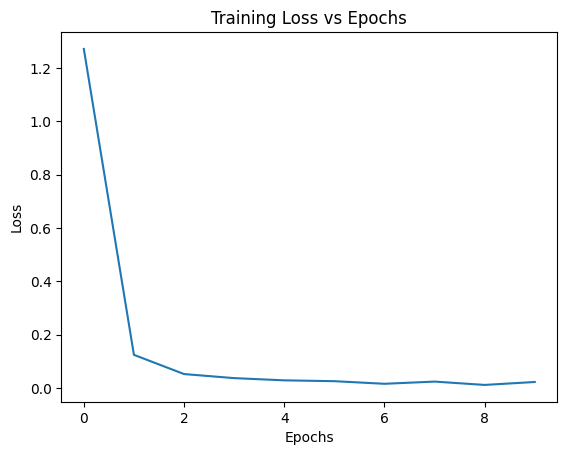

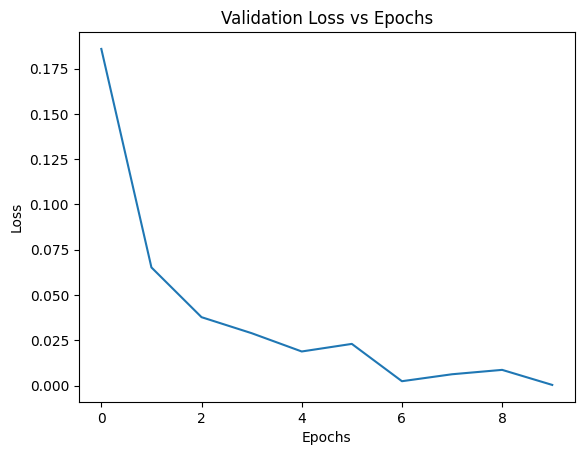

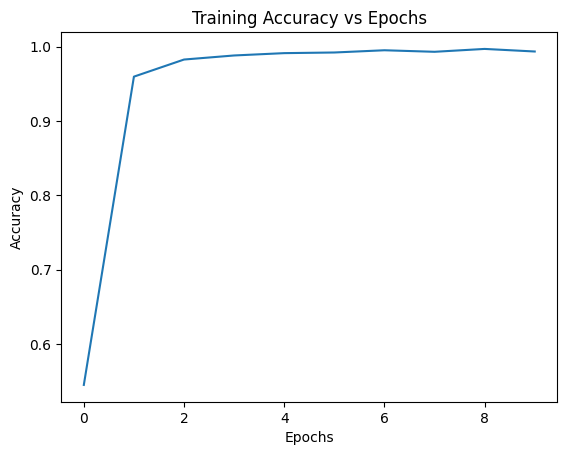

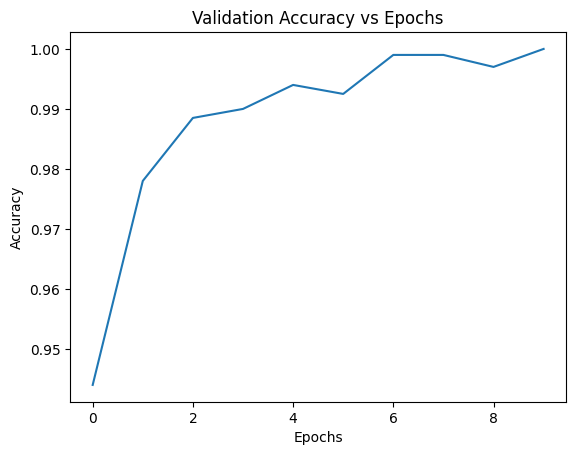

In [126]:
import matplotlib.pyplot as plt
plt.plot(train_loss,label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.show()
plt.plot(validation_loss,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epochs')
plt.show()
plt.plot(training_accuracy,label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epochs')
plt.show()
plt.plot(validation_accuracy,label='Validation Accuracy')
plt.xlabel('Epochs')    
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.show()

In [118]:
#saving the weights of the model for our future reference
torch.save(model.state_dict(), 'model.pth')
#https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [119]:
model = AlexNet(10)
checkpoint = torch.load('model.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
#checking the accuracy of the model using weights saved
accuracy(test_loader,model)

(0.9993333333333333, 0.9993161893629455, 0.999390243902439, 0.9993516987438442)